In [1]:
from SimPEG import *
from simpegEM1D import *
from scipy.constants import mu_0
import numpy as np
frequency = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
hz = get_vertical_discretization_frequency(frequency, sigma_background=0.01)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

FDsurvey = EM1DSurveyFD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    field_type = 'secondary',
    rx_type = 'Hz',
    src_type = 'VMD',
    offset = np.ones(5)*7.86,
    topo = np.r_[0., 0., 100.],
    depth = depth,
    frequency = frequency
)

sig_half = 1e-3
sig_blk = sig_half*50.
chi_half = 0.
expmap = Maps.ExpMap(mesh1D)
sig  = np.ones(FDsurvey.n_layer)*sig_half
blk_ind = (-50>LocSigZ) & (-80<LocSigZ)
sig[blk_ind] = sig_blk
# sig[-150>LocSigZ] = 0.1
m_true = np.r_[np.log(sig)]

In [4]:
prob = EM1D(
    mesh1D, sigmaMap=expmap,
    chi= np.zeros(FDsurvey.n_layer),
    verbose=False
)
if prob.ispaired:
    prob.unpair()
if FDsurvey.ispaired:
    FDsurvey.unpair()
prob.pair(FDsurvey)     
d_true = FDsurvey.dpred(m_true)
m0 = np.ones_like(m_true) * np.log(sig_half)
d_0 = FDsurvey.dpred(m0)

In [5]:
FDsurvey.dtrue = d_true
std = 0.05
floor = 0.
np.random.seed(1)
uncert = std*abs(FDsurvey.dtrue)+floor
noise = std*FDsurvey.dtrue*np.random.randn(FDsurvey.dtrue.size)
FDsurvey.dobs = FDsurvey.dtrue+noise
doi, _=prob.depth_of_investigation(uncert)
delta = prob.get_threshold(uncert)

In [6]:
print (doi, delta)

172.35910288100044 0.01595579499674474


In [7]:
from SimPEG import Regularization

In [8]:

dmisfit = DataMisfit.l2_DataMisfit(FDsurvey)
dmisfit.W = 1./(abs(FDsurvey.dobs)*std+floor)

reg = Regularization.Sparse(
    mesh1D, mapping=Maps.IdentityMap(mesh1D)
)
p=0.
qx, qz = 2., 2.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=10, minGNiter=1, fix_Jmatrix=False, coolingRate=2, 
    betaSearch=False,
    chifact_start = 2.
)
opt = Optimization.ProjectedGNCG(maxIter = 30)
opt.maxIterLS = 5
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit()
sense = Directives.UpdateSensitivityWeights(threshold=delta)
# inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS, betaest])

prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.70e+01  8.42e+02  0.00e+00  8.42e+02    6.45e+01      0              


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:903: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


   1  1.70e+01  6.82e+02  2.87e+00  7.31e+02    3.83e+01      0              
   2  8.52e+00  5.82e+02  6.27e+00  6.35e+02    6.55e+01      0   Skip BFGS  
   3  8.52e+00  2.59e+02  1.96e+01  4.26e+02    1.02e+02      0              
   4  4.26e+00  1.91e+01  2.91e+01  1.43e+02    4.93e+01      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 4.466130396693773 eps_q: 4.466130396693773
Eps_p: 3.721775330578144
Eps_q: 3.721775330578144
delta phim:    inf
   5  4.26e+00  6.01e+00  3.71e+01  1.64e+02    4.67e+01      0              
Eps_p: 3.1014794421484533
Eps_q: 3.1014794421484533
delta phim: 7.944e-01
   6  1.98e+00  1.16e+01  3.47e+01  8.03e+01    1.15e+02      0              
Eps_p: 2.584566201790378
Eps_q: 2.584566201790378
delta phim: 5.088e-01
   7  1.19e+00  7.09e+00  3.25e+01  4.59e+01    7.30e+00      0   Skip BFGS  
Eps_p: 2.1538051681586485
Eps_q: 2.1538051681586485
delta phim: 9.502e-02
   8  6.91e-01  7.60e+00  3.08e+01  2.89e

In [9]:
doi, act_ind = prob.depth_of_investigation(uncert)

In [10]:
print (doi)

230.0630993146064


Populating the interactive namespace from numpy and matplotlib


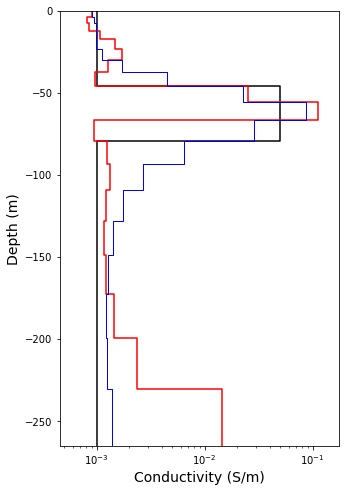

In [12]:
%pylab inline
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D, showlayers=False)
Utils1D.plotLayer(expmap*mopt, mesh1D, showlayers=False, **{'color':'r'})
Utils1D.plotLayer(expmap*invProb.l2model, mesh1D, showlayers=False, **{'color':'b', 'lw':1})

In [13]:
print (doi)

230.0630993146064


In [14]:
delta = prob.get_threshold(uncert)

In [15]:
print (delta)

0.01310619745771359


In [16]:
# !python run_em1d.py

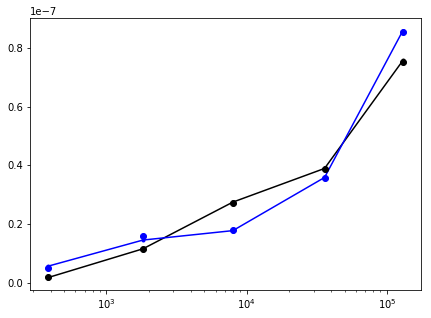

In [17]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(FDsurvey.frequency, -invProb.dpred[0:FDsurvey.n_frequency], 'k.-')
axes.plot(FDsurvey.frequency, -invProb.dpred[FDsurvey.n_frequency:], 'b.-')
axes.plot(FDsurvey.frequency, -FDsurvey.dobs[0:FDsurvey.n_frequency], 'ko')
axes.plot(FDsurvey.frequency, -FDsurvey.dobs[FDsurvey.n_frequency:], 'bo')
# axes.plot(FDsurvey.frequency, uncert[0:FDsurvey.n_frequency], 'k*')
# axes.plot(FDsurvey.frequency, uncert[FDsurvey.n_frequency:], 'r*')
axes.set_xscale('log')

In [18]:
from scipy.linalg.blas import cgemm
import numpy as np

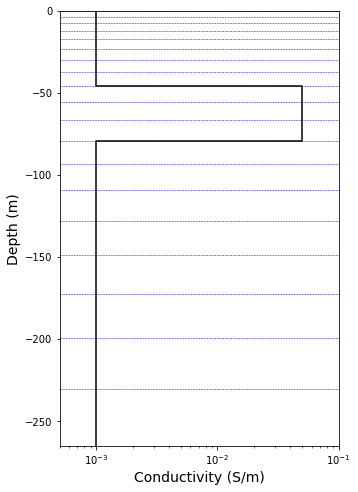

In [20]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D, showlayers=True)